![014_003.png](../22_assets/images/014_003.png)

# Motivation and Introduction

As an avid spreadsheet user myself, textual or non-numeric data always felt beyond reach within the tiny rectangular cells that together form a second home for the analyst. Today, we address this shortcoming by exploring how Natural Language Processing (NLP) can be used to quantify the text recipe labels(tags) of 40,000 food recipes scraped from [Allrecipes](www.allrecipes.com). Although a simple and crude application of machine learning data preprocessing, this exercise revealed that the most popular recipe label was "dessert" along with other relationships, such as how labels representing liquids tend to have higher ratings compared to labels representing solid foods such as meats.

NLP and text analysis are useful for analyzing the large amounts of non-numeric data posted on the web by creators and publishers on a daily basis to answer business questions such as:
- what are the latest trends in recipe labels?
- do some recipe labels attract more user engagement and better ratings than others?
- are there areas of improvement for label consolidation to create a more focused content universe for recipe consumers?
- how do the recipes on allrecipes.com compare to other recipe websites?

In this article, the data was loaded from AWS S3, cleaned, then preprocessed into tokens before being fed into a CountVectorizer, which counts the frequency of each token appearing within each recipe. The output of the vectorizer was used for numerical and visual analysis. A visual overview of the process is available below:

![014_002.png](../22_assets/images/014_002.png)

# Overview of Setup

## Docker Environments

To replicate the environment used to perform this analysis:
1. fork the Github [repository](https://github.com/andrewyewcy/recipe_classifier) locally on a Docker and Docker-compose installed machine
2. run below line in Terminal within the file directory of the repository

In [1]:
# Run below line in terminal within the folder that contains the forked repo
# docker-compose -f dev_setup.yaml up

Instructions on how to access Jupyter will be generated in the Terminal. Detailed installation documentation can be found within the README of the repository. 

## Import Packages and Define Functions

The [`natural language toolkit(NLTK)`](https://www.nltk.org/) and the [`CountVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) within `scikit-learn` were used to process and transform the recipe label text into tokens.

In [2]:
# Packages for general data processing
import numpy as np
import pandas as pd
import joblib       # Loading data
import time         # Measuring time
import ast          # Reading lists within pandas DataFrame

# Packages for loading data from AWS S3 bucket
import boto3
import pickle
from io import BytesIO                          # Read file without writing to disk
from dotenv import load_dotenv                  # Import hidden access credentials into OS
import os                                       # Access loaded credential in OS
from notebook_functions.timer import print_time # Custom function for printing time

# Packages for data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from notebook_functions.plot import plot_histogram # Custom function to plot distribution
from notebook_functions.print import print_list    # Custom function for list printing
from adjustText import adjust_text                 # Function for optimizing text label display on scatter plot https://github.com/Phlya/adjustText

# Packages for pre-processing text
import nltk                       # Natural Language Tool Kit
nltk.download('stopwords')        # For processing stop words (words too common to hold significant meaning)
from nltk.corpus import stopwords # Import above downloaded stopwords
import re                         # Regular Expression
import string                     # For identifying punctuation

# Packages for processing text
from sklearn.feature_extraction.text import CountVectorizer

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Import Data From AWS S3

The data was stored in an AWS Simple, Storage, Service (S3) bucket, which is a cloud storage service that integrates well with other AWS applications like EC2 and EMR. To access AWS S3 with python, the [`boto3`](https://boto3.amazonaws.com/v1/documentation/api/latest/index.html) module by AWS was used.

The data contains the various numerical and textual elements of 40,000 recipes web-scraped off Allrecipes.com between the months of February and March 2023. For access to the complete data, please contact the author of the article.

## Data Dictionary

![014_001.jpg](../22_assets/images/014_001.jpg)

The above image illustrates where the recipe labels are located in any recipe found on allrecipes.com. The below data dictionary explains the 5 columns which will be used for analysis in this article.

| Column | Type | Description |
|---|---|---|
| `recipe_url` | hyperlink | The uniform resource locator(URL) that leads to the recipe hosted on Allrecipes.com |
| `title` | text | The title of each recipe |
| `label` | text | The labels (tags) for each recipe. Used by Allrecipes.com as a method of organizing recipes |
| `rating_average` | float | The rounded average as found on each recipe on Allrecipes.com |
| `rating_count` | integer | The number of ratings for each recipe |

## Instantiate AWS S3 Client and Resource Interfaces

In [3]:
# Load hidden credentials from .env file
load_dotenv()

True

In [4]:
# Instantiate AWS S3 Client interface for examining S3 bucket details
s3_client = boto3.client(
    "s3",
    aws_access_key_id     = os.environ.get("aws_access_key_id"),
    aws_secret_access_key = os.environ.get("aws_secret_access_key")
)

# Examine the client object
print(type(s3_client))

<class 'botocore.client.S3'>


In [5]:
s3_resource = boto3.resource(
    "s3",
    aws_access_key_id     = os.environ.get("aws_access_key_id"),
    aws_secret_access_key = os.environ.get("aws_secret_access_key")    
)

# Examine the resource object
print(type(s3_resource))

<class 'boto3.resources.factory.s3.ServiceResource'>


## Check File Size and Import Data

In [6]:
# Define bucket and file names to be read from AWS S3 Bucket
bucket_name = "aycy-recipe-classifier"
file_name = "recipe_label_df.pkl"

# Gather a response of objects within specified AWS S3 bucket
response = s3_client.list_objects_v2(Bucket = bucket_name)

# Examine size of objects within bucket
for index, object in enumerate(response["Contents"]):
    print(f"# {index}: {object['Key']}, {object['Size']:_} bytes")

# 0: recipe_label_df.pkl, 5_539_560 bytes
# 1: recipe_url_df.pkl, 3_089_204 bytes


The target file `recipe_label_df.pkl` was observed to have a size of 5.5 megabytes. To avoid saving the file on local system, the BytesIO() class from the [io module](https://docs.python.org/3/library/io.html#io.BytesIO) was used to stream the data from the AWS S3 bucket directly to this Python session.

In [7]:
# Stream the data file from AWS S3 bucket into environment without saving locally.
with print_time():
    with BytesIO() as data:
        s3_resource.Bucket(bucket_name).download_fileobj(file_name, data)
        data.seek(0) # move back to the beginning after writing
        df = joblib.load(data)

Time taken: 1.4465 seconds.


The time taken to import data can be further shortened if this analysis was performed on an AWS EC2 or Sagemaker instance. Next, the data was examined to identify any data cleaning requirements.

In [8]:
print(f"There are {df.shape[0]} recipes with {df.shape[1]} columns.")

There are 40001 recipes with 5 columns.


In [9]:
# Visually examine loaded data
display(df.head(2).T)

,0,1
recipe_url,https://www.allrecipes.com/recipe/83646/corned...,https://www.allrecipes.com/recipe/158799/stout...
title,Corned Beef Roast,Stout-Braised Lamb Shanks
label,"['Recipes', 'Main Dishes', 'Beef', 'Corned Bee...","['Cuisine', 'European', 'UK and Ireland', 'Iri..."
rating_average,4.4,4.5
rating_count,68,45


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40001 entries, 0 to 40000
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   recipe_url      40001 non-null  object 
 1   title           39994 non-null  object 
 2   label           39994 non-null  object 
 3   rating_average  36420 non-null  float64
 4   rating_count    36420 non-null  object 
dtypes: float64(1), object(4)
memory usage: 1.5+ MB


Issues with the loaded data:
1. The `rating_count` column was found to be of `object` type instead of `int`.
2. Null values observed for `title`, `label`, `rating_average`,and `rating_count`.

# Data Cleaning and EDA

Before preprocessing the recipe label text for analysis, data cleaning and exploratory data analysis (EDA) was performed for the other columns to address the issues identified during data import.

## Null `titles`

Out of 40,001 recipes, 7 recipes were found to have null titles.

In [11]:
# Examine null titles
cond = df['title'].isnull()

print(f"Number of null titles: {cond.sum()}, {np.round(cond.sum()/df.shape[0]*100,2)}% of recipes")

# Visually examine null titles
df.loc[cond]

Number of null titles: 7, 0.02% of recipes


,recipe_url,title,label,rating_average,rating_count
22785,https://www.allrecipes.com/cook/thedailygourme...,NaN,NaN,NaN,NaN
23968,https://www.allrecipes.com/recipe/14759/pork-d...,NaN,NaN,NaN,NaN
26010,https://www.allrecipes.com/recipe/218445/lenge...,NaN,NaN,NaN,NaN
26389,https://www.allrecipes.com/recipe/cajun-spice-...,NaN,NaN,NaN,NaN
26848,https://www.allrecipes.com/recipe/herman-sourd...,NaN,NaN,NaN,NaN
27388,https://www.allrecipes.com/recipe/mustard-pork...,NaN,NaN,NaN,NaN
33171,https://www.allrecipes.com/recipe/biga/detail....,NaN,NaN,NaN,NaN


As the adherence of each recipe to a standard structure within Allrecipes.com was not well understood, it was assumed that these recipes may be published with some error and thus excluded from analysis.

In [12]:
# Drop rows with null titles
df = df.loc[~cond]

In [13]:
# Examine null values again
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39994 entries, 0 to 40000
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   recipe_url      39994 non-null  object 
 1   title           39994 non-null  object 
 2   label           39994 non-null  object 
 3   rating_average  36420 non-null  float64
 4   rating_count    36420 non-null  object 
dtypes: float64(1), object(4)
memory usage: 1.8+ MB


## Null `rating_average` and `rating_count`

Before dealing with null values in these two columns, the `rating_count` column was found to be stored as `object` data type rather than `int`.

In [14]:
# Try to convert the `rating_count` column to integer
try:
    df['rating_count'].astype('int')
except ValueError as e:
    print(f"{str(e)}")

invalid literal for int() with base 10: '2,630'


It would appear that thousands are separated with a comma, leading to the error in type conversion.

In [15]:
# Remove comma from `rating_count`, then fill NaN with 0 for conversion to integer
try:
    df['rating_count'] = df['rating_count'].str.replace(",","").fillna(0).astype('int')
except ValueError as e:
    print(f"{str(e)}")

In [16]:
# Examine the converted rating_count
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39994 entries, 0 to 40000
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   recipe_url      39994 non-null  object 
 1   title           39994 non-null  object 
 2   label           39994 non-null  object 
 3   rating_average  36420 non-null  float64
 4   rating_count    39994 non-null  int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 1.8+ MB


Note the recipes with previously null rating counts were now filled with 0, which makes sense since having no ratings was assume to equal 0 ratings. Now, the null values for `rating_average` were examined in greater detail.

In [18]:
# Drop the recipes with null rating_average
cond = df['rating_average'].isnull()

print(f"Number of null titles: {cond.sum()}, {np.round(cond.sum()/df.shape[0]*100,2)}% of remaining recipes")

# Visually examine null titles
df.loc[cond].head()

Number of null titles: 3574, 8.94% of remaining recipes


,recipe_url,title,label,rating_average,rating_count
123,https://www.allrecipes.com/recipe/8538705/tate...,Tater Tot Hotdish,"['Main Dishes', 'Casserole Recipes', 'Vegetabl...",NaN,0
188,https://www.allrecipes.com/recipe/8493351/grai...,Grain-Free Broccoli Fritters,"['Recipes', 'Fruits and Vegetables', 'Vegetabl...",NaN,0
260,https://www.allrecipes.com/recipe/8499644/chic...,Chicken Minestrone Soup,"['Soups, Stews and Chili Recipes', 'Soup Recip...",NaN,0
261,https://www.allrecipes.com/recipe/8532495/roas...,Roasted Broccoli Soup,"['Soups, Stews and Chili Recipes', 'Soup Recip...",NaN,0
263,https://www.allrecipes.com/recipe/8448142/wate...,Watermelon Tomato Gazpacho with a Cool Cucumbe...,"['Soups, Stews and Chili Recipes', 'Soup Recip...",NaN,0


Although a significant 8.94% of remaining recipes were found to have null ratings, these recipes were dropped from analysis as the focus of this exercise was to analyze the labels of recipes and any relationships it might have with other metrics.

In [19]:
# Drop ropws where the rating_average is null
df = df.loc[~cond]

In [20]:
# Check for any null values
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36420 entries, 0 to 40000
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   recipe_url      36420 non-null  object 
 1   title           36420 non-null  object 
 2   label           36420 non-null  object 
 3   rating_average  36420 non-null  float64
 4   rating_count    36420 non-null  int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 1.7+ MB


In [21]:
# Double check for null values
df.isna().sum().sum()

0

All null values have been removed.

## Distribution of `rating_average` and `rating_count`

===== Distribution Plots for rating_average =====


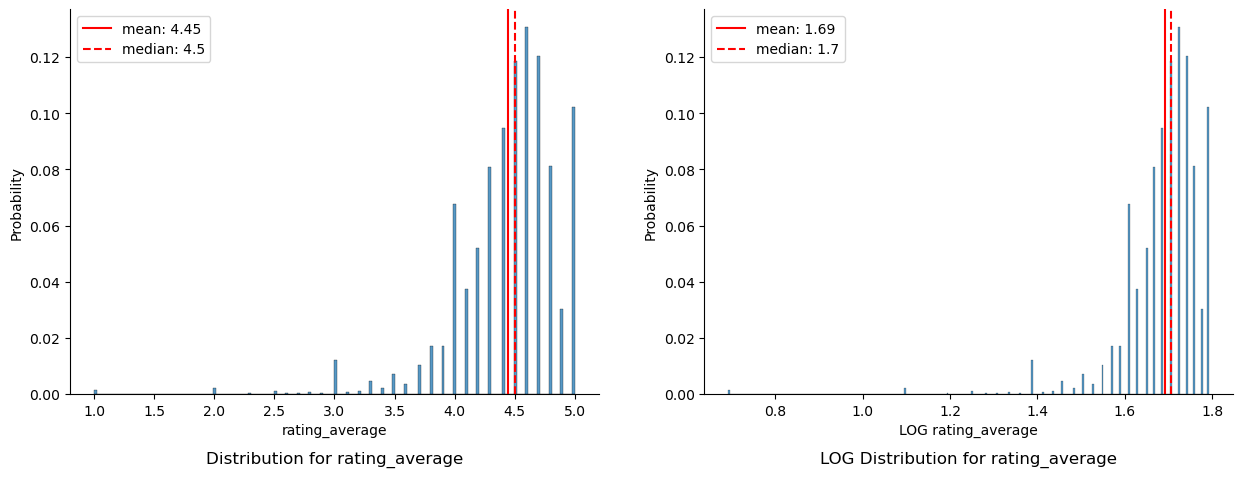



===== Distribution Plots for rating_count =====


<Figure size 640x480 with 0 Axes>

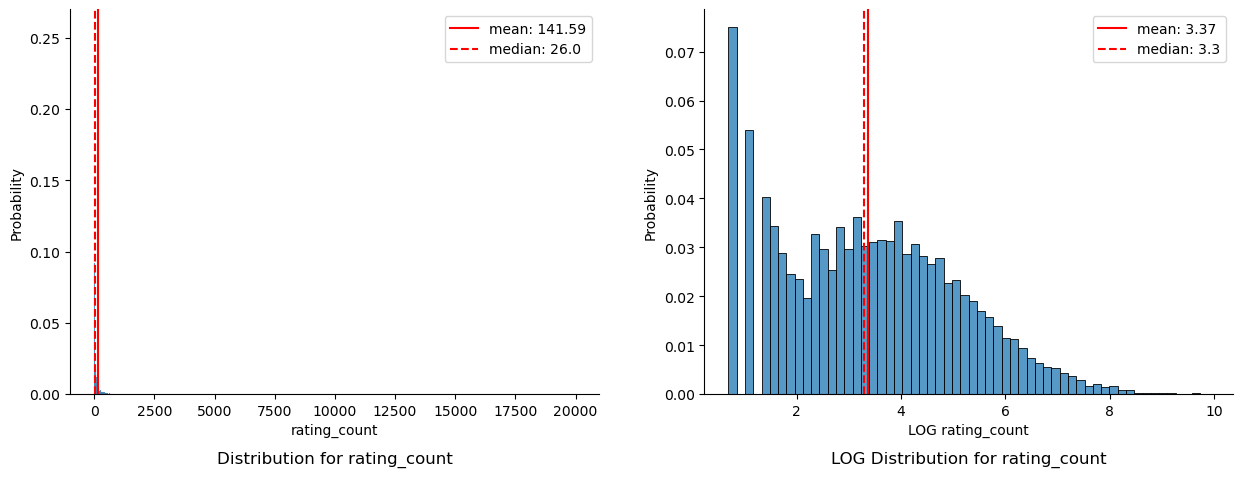

<Figure size 640x480 with 0 Axes>

In [22]:
# For specified columns, call the custom plotting function to examine distribution
# Details on the plotting function can be found in the Github repo under the folder notebook_functions
for col in ["rating_average","rating_count"]:
    plot_histogram(df, col, col,"../22_assets/images")

A left skew was observed for `rating_average` with a mean average rating of 4.5 out of 5. Although the close mean and median suggest a distribution with a single peak, visual observation suggests multiple peaks centered around 4.0, 4.5 and 5.0 respectively. These observations suggest that users who do provide ratings tend to provide high ratings of 4 to 5 stars, and, that the `rating_average` may be an over-positive representation of recipes posted on allrecipes.

`Rating_count` was observed to have an extremely right skew, with the mean of 142 ratings per recipe being 5 times greater than the median of 26 ratings per recipe. The skew is mostly caused by outlier recipes with over 10,000 user ratings, as confirmed by the mellowed LOG distribution. This may suggest that the promotion or recommendation of recipes on allrecipes.com highly favours recipes already popular, or that some recipes are so common that many people search for it. Further detailed exploration by recipe is required to verify this. The LOG of the `rating_count` reduces the effect of outliers and reveals a bimodal distirbution. The taller peak of the left suggests most recipes tend to have low rating counts, with the smaller peak on the right representing the next majority of recipes centered around 1,000 ratings per recipe.

## Recipes with Less than 2 ratings

The significance of recipe ratings are dependent on the number of ratings. Thus, to ensure some standard of quality for recipes, recipes with less than 2 ratings were excluded from analysis. The number of 2 was chosen based on the assumption that a second independent rating sufficiently raises the validity of the recipe rating.

In [25]:
# Identify the number of recipes with less than 2 ratings
cond = df["rating_count"] < 2

print(f"Number of recipes with less than 2 ratings: {cond.sum()}, {np.round(cond.sum()/df.shape[0]*100,2)}% of remaining recipes")

# Visual examination of these recipes
df.loc[cond].head()

Number of recipes with less than 2 ratings: 2729, 7.49% of remaining recipes


,recipe_url,title,label,rating_average,rating_count
2,https://www.allrecipes.com/recipe/8509102/chic...,Chicken Al Pastor,"['Mexican', 'Main Dishes', 'Tacos', 'Chicken']",5.0,1
186,https://www.allrecipes.com/recipe/8532964/air-...,Air Fryer Tilapia,"['Recipes', 'Seafood', 'Fish', 'Tilapia']",5.0,1
189,https://www.allrecipes.com/recipe/8441918/skil...,Skillet Zucchini and Squash,"['Vegetables', 'Squash', 'Summer Squash', 'Yel...",5.0,1
190,https://www.allrecipes.com/recipe/8499615/air-...,Air Fryer Scrambled Eggs On The Go,"['Recipes', 'Breakfast and Brunch', 'Eggs', 'S...",4.0,1
262,https://www.allrecipes.com/recipe/8532956/dump...,Dump-and-Go Instant Pot Tortilla Soup,"['Recipes', 'Soups, Stews and Chili Recipes', ...",4.0,1


===== Distribution Plots for rating_average =====


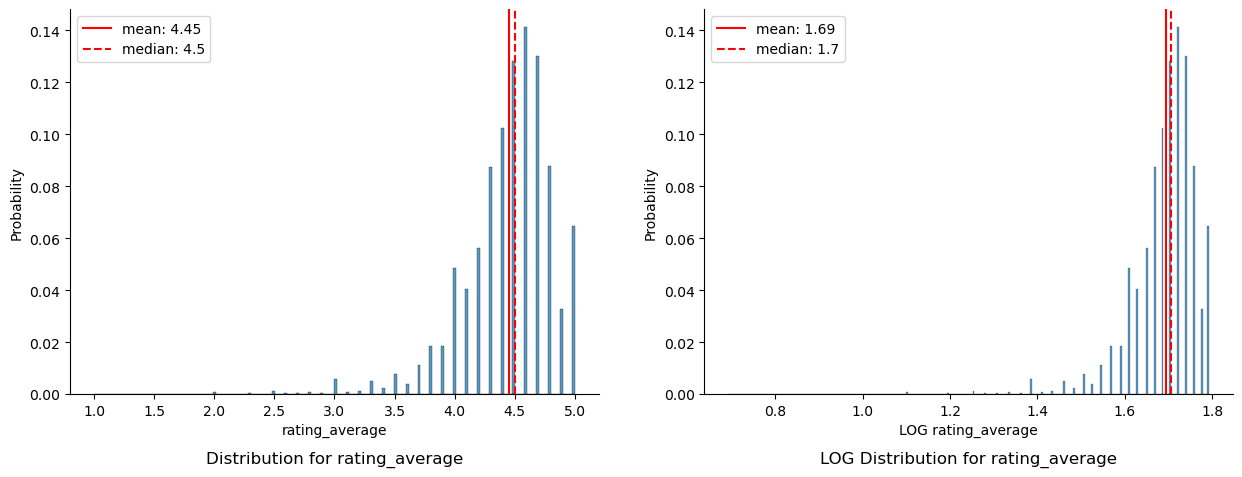



===== Distribution Plots for rating_count =====


<Figure size 640x480 with 0 Axes>

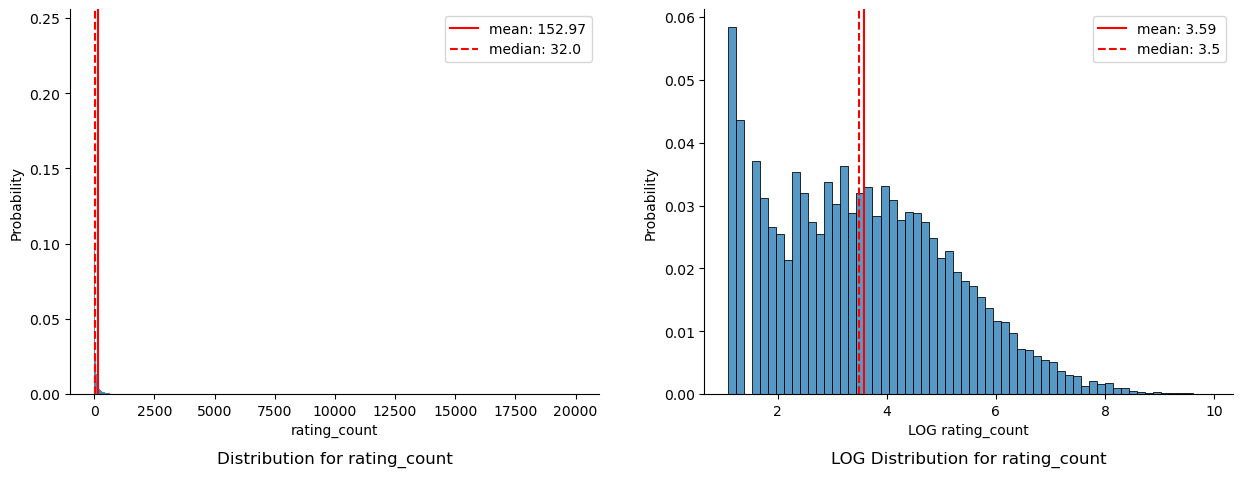

<Figure size 640x480 with 0 Axes>

In [24]:
# Re-examine the distribution after excluding the recipes with less than 2 ratings
for col in ["rating_average","rating_count"]:
    plot_histogram(df.loc[~cond], col, col,"../22_assets/images")

Although 7.49% of the remaining recipes contain less than 2 ratings, the validity of the quality of the recipes being analyzed is deemed more important than the number of recipes analyzed, and thus these 2,729 recipes were dropped from analysis. Further backing up this decision, the distribution of `rating_count` and `rating_average` were observed to be unchanged after removing recipes with less than 2 ratings.

In [26]:
# Drop ropws where the recipe has less than 2 ratings
df = df.loc[~cond]

In [27]:
# Examine remaining recipes
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33691 entries, 0 to 40000
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   recipe_url      33691 non-null  object 
 1   title           33691 non-null  object 
 2   label           33691 non-null  object 
 3   rating_average  33691 non-null  float64
 4   rating_count    33691 non-null  int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 1.5+ MB


In [28]:
# Numerical examination of cleaned distribution
df.describe()

,rating_average,rating_count
count,33691.000000,33691.000000
mean,4.451895,152.973316
std,0.381909,538.782772
min,1.000000,2.000000
25%,4.300000,9.000000
50%,4.500000,32.000000
75%,4.700000,108.000000
max,5.000000,19961.000000


In [29]:
# Reset index for easier table joining later
df.reset_index(drop = True, inplace = True)

## Data Cleaning Summary

| Data Cleaning | Recipes Affected | Decision | Recipes Remaining | Justification |
|---|---|---|---|---|
| Original | - | - | 40,001 | - |
| Null `titles` | 7 | Drop rows | 39,994 | Likely error in recipe publication. |
| Null `rating_average` | 3,574 | Drop rows | 36,420 | Need rating to perform multivariate analysis. |
| Recipes less than 2 ratings | 2,729 | Drop rows | 33,691 | Need recipes that have significant ratings. |

# Text Preprocessing

Now, the `labels` column containing recipe label texts can be pre-processed for vectorization. This step is essential to maximize the meaning of generated tokens.

In [30]:
# As only 5 rows were examined, the slower iterrows method was used for code simplicity
for index, row in df.loc[:,["title", "label"]].head().iterrows():
    print(f"{row[0]} has labels:    {row[1]}")

Corned Beef Roast has labels:    ['Recipes', 'Main Dishes', 'Beef', 'Corned Beef Recipes']
Stout-Braised Lamb Shanks has labels:    ['Cuisine', 'European', 'UK and Ireland', 'Irish']
Mississippi Chicken has labels:    ['Recipes', 'Meat and Poultry', 'Chicken']
Lasagna Flatbread has labels:    ['Recipes', 'Bread', 'Quick Bread Recipes']
Prosciutto-Wrapped Pork Tenderloin with Crispy Sage has labels:    ['Recipes', 'Meat and Poultry', 'Pork', 'Pork Tenderloin Recipes']


The labels for each recipe were observed to be a list of terms separated by commas. Furthermore, the number of labels and the labels themselves are not consistent across recipes. Common words such as "Recipes" were observed to bring no analysis value as each row represents a recipe by default. 

As such, before vectorizing the recipe labels into a sparse table containing a count for each token, preprocessing of text shold be performed to ensure that only meaningful labels are included. In other words, the text column containing recipe labels must be cleaned.

To facilitate systematic cleaning of each recipe's text, a `tokenizer` was built, with the recipe `Corned Beef Roast` being the recipe evaluated as the tokenizer is built.

In [31]:
# Visually examine the labels of Corned Beef Roast, which is index 0
sentence = df.loc[0,"label"]
print(sentence)

['Recipes', 'Main Dishes', 'Beef', 'Corned Beef Recipes']


## Remove Punctuation

To get a list of punctuation to remove, the punctuation attribute of the `string` module was accessed.

In [32]:
# punctuation to remove
print(string.punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


Removing the punctuation from the labels of Corned Beef Roast leads to each word being separated by space. Although cleaner, this is not ideal as the words `main` and `dishes` make more sense together than when evaluated separately. 

In [33]:
# Remove punctuation and change to lower case
for punctuation_mark in string.punctuation:
    sentence = sentence.replace(punctuation_mark, "").lower()

print(sentence)

recipes main dishes beef corned beef recipes


One option is to use the `n-grams` option in the `CountVectorizer` later. However, since the inclusion of n-grams significantly increases the number of tokens formed, combined with the simplicity of the text, a custom word-combiner was used instead to remove punctuation to generate more meaning. Regular Expression ([regex](https://docs.python.org/3/library/re.html)) was used to specify which punctuation to remove.

In [34]:
# Regenerate Corned Beef Roast labels
sentence = df.loc[0,"label"]

# STEP 1: Replace all spaces after commas with placeholder "+"
sentence = re.sub(",\s","+",sentence)
print(f"STEP1: {sentence}")

# STEP 2: Replace all other spaces within quotation marks with "_"
sentence = re.sub("\s","_",sentence)
print(f"STEP2: {sentence}")

# STEP 3: Revert the placeholder to back to original space to separate labels
sentence = sentence.replace("+",", ")
print(f"STEP3: {sentence}")

# STEP 4: Finally, remove all punctuation except "_"
for punctuation_mark in [punctuation for punctuation in string.punctuation if punctuation != "_"]:
    sentence = sentence.replace(punctuation_mark,"").lower()

print(f"STEP4: {sentence}")

STEP1: ['Recipes'+'Main Dishes'+'Beef'+'Corned Beef Recipes']
STEP2: ['Recipes'+'Main_Dishes'+'Beef'+'Corned_Beef_Recipes']
STEP3: ['Recipes', 'Main_Dishes', 'Beef', 'Corned_Beef_Recipes']
STEP4: recipes main_dishes beef corned_beef_recipes


Now, as seen in step 4 above, all other punctuation marks have been removed while preserving meaningful word combinations for recipe labels.

## Remove Numbers

Similar to punctuation, the `digits` attribute of the `string` module can be used to remove digits. In this specific context of recipe labels, numerical digits do not hold much meaning and were thus removed.

In [35]:
# Examing numerical digits to be removed
print(string.digits)

0123456789


The `maketrans()` method was used as a faster alternative to looping through each character.

In [36]:
# Each digit within string.digits is mapped to None
remove_digits = str.maketrans('','', string.digits)

# Apply mapping to sentence
sentence = sentence.translate(remove_digits)

print(sentence)

recipes main_dishes beef corned_beef_recipes


As expected, no changes were observed since no numerical digits were present in the example. To prove that numerical digits are being removed, the below simple test case was created:

In [37]:
# Example with numbers inside
test_sentence = "recipes main_dishes11111 beef2222 corned_beef_recipes"
print(f"Test with numbers: {test_sentence}")

# Apply mapping to remove digits to test sentence
test_sentence = test_sentence.translate(remove_digits)

print(test_sentence)

Test with numbers: recipes main_dishes11111 beef2222 corned_beef_recipes
recipes main_dishes beef corned_beef_recipes


## Remove Stop Words + Stemming

Stop Words refer to words that appear so commonly that they hold no significant meaning. A list of English stop words was accessed through the Natural Language ToolKit ([NLTK](https://www.nltk.org/)) corpus, and further extended to include words specific to this use case.

In [38]:
# Examine first 10 stopwords in enlish
eng_stopwords = stopwords.words('english')
print(eng_stopwords[0:10])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


In [39]:
# Include some stop words in food recipes
eng_stopwords.extend(['degree','degrees','c','f', 'recipe', 'recipes', 'minute', 'minutes', 'cuisine', 'cuisines'])

After defining stop words to exclude from analysis, the variant of each word can be standardized using stemming. Stemming is an imperfect solution to standardizing variants of words, such as the "s" at the end of plural forms.

Note that each sentence was broken up into words based on whitespaces as meaningful combinations of words were already accounted for when removing punctuation.

In [40]:
# Define a stemmer
stemmer = nltk.stem.PorterStemmer()

In [41]:
print(f"Before stemming and stop word removal:    {sentence}")

# Split sentence into words based on spaces
list_of_words = sentence.split(' ')

# Define blank list to store stemmed words
list_of_stemmed_words = []

for word in list_of_words:
    
    # Remove stop words and and any tokens that are just empty strings
    if (not word in eng_stopwords) and word != "":

        # Stem each word
        list_of_stemmed_words.append(stemmer.stem(word))

# Examine sentence after stemming and stop word removal
print(f"After stemming and stop word removal:    {list_of_stemmed_words}")

Before stemming and stop word removal:    recipes main_dishes beef corned_beef_recipes
After stemming and stop word removal:    ['main_dish', 'beef', 'corned_beef_recip']


As expected, the word `recipes` was removed since it was defined as a stop word. The stemming worked as expected as the plurality of `main_dishes` was removed, leaving `main_dish`. Stemming is not a perfect process as `corned_beef_recipes` was stemmed to `corned_beef_recip`. 

## Compilation into a Tokenizer function

The above text preprocessing steps were combined into a function to be applied to each recipe. 

In [42]:
def tokenizer(sentence):
    """
    This function performs the tokenization of text with below steps:
    1) removes punctuation and combines meaningful labels with underscore
    2) removes numerical digits
    3) splits a sentence into words based on white space
    4) removes stop words
    5) apply PorterStemmer to each word

    ======
    INPUTS
    ======
    sentence: a string object to be tokenized

    =======
    OUTPUTS
    =======
    stemmed_tokens: a list of stemmed tokens

    =======
    EXAMPLE
    =======
    Given:
    sentence = "['Recipes', 'Main Dishes', 'Beef', 'Corned Beef Recipes']"
    print(type(sentence))
    >>> str
    
    tokens = tokenizer(sentence)
    print(tokens)
    >>> ['main_dish', 'beef', 'corned_beef_recip']
    
    print(type(tokens))
    >>> list
    """

    assert isinstance(sentence,str), "Passed object is not string"
    
    # Define variables
    punctuation_to_remove = [punctuation for punctuation in string.punctuation if punctuation != "_"]
    digits_to_remove      = string.digits
    stemmer               = nltk.stem.PorterStemmer()
    stemmed_tokens        = [] # Initiate blank link for storing tokens
    eng_stopwords         = stopwords.words('english')
    eng_stopwords.extend(['degree','degrees','c','f', 'recipe', 'recipes', 'minute', 'minutes', 'cuisine','cuisines'])
    
    # Remove punctuation and combine meaningful words
    sentence = re.sub(",\s","+",sentence) # STEP 1: Replace all spaces after commas with placeholder "+"
    sentence = re.sub("\s","_",sentence)  # STEP 2: Replace all other spaces within quotation marks with "_"
    sentence = sentence.replace("+",", ") # STEP 3: Revert the placeholder to back to original space to separate labels
    for punctuation_mark in punctuation_to_remove:
        sentence = sentence.replace(punctuation_mark,"").lower()

    # Remove numerical digits using mapper
    remove_digits_mapper = str.maketrans('','', digits_to_remove)
    sentence = sentence.translate(remove_digits_mapper)

    # Split sentence into individual tokens
    tokens = sentence.split(' ')

    for token in tokens:
        # Remove stop words and and any tokens that are just empty strings
        if (not token in eng_stopwords) and token != "":
            # Stem each token
            stemmed_tokens.append(stemmer.stem(token))

    return stemmed_tokens

In [43]:
# Testing the function
sentence = df.loc[0,"label"]
print(f"Recipe labels before tokenization:    {sentence}")

# Apply the tokenizer
tokens = tokenizer(sentence)
print(f"Recipe labels after tokenization:    {tokens}")

Recipe labels before tokenization:    ['Recipes', 'Main Dishes', 'Beef', 'Corned Beef Recipes']
Recipe labels after tokenization:    ['main_dish', 'beef', 'corned_beef_recip']


The tokenizer works as expected based on the test case of Corned Beef Roast.

# CountVectorizor

## Testing with Smaller Sample

As the main purpose was the analysis of recipe label texts, the recipe labels were quantified by simply counting the frequency of tokens(recipe labels) in each recipe, otherwise known as count-vectorizing. A test on a smaller sample of data was performed to understand the performance of vectorization as it can be a time consuming process. Each token becomes a column, and, given a large corpus (many recipes), a large sparse table could be generated. 

This approach is commonly known as "bagofwords" approach as grammar and the order of words were ignored. Counting the frequency of tokens is akin to counting how many different objects of each type are inside a bag. Usually this process would be part of a machine learning pipeline, but is useful in and of itself for analysis such as these.

In [44]:
# Define a CountVectorizer model that uses the tokenizer previously defined
bagofwords = CountVectorizer(
    tokenizer = tokenizer
)

# Tell the Vectorizer what tokens there are by fitting it to the first two recipes for testing
with print_time():
    bagofwords.fit(df["label"].head(2))

Time taken: 0.0065 seconds.


/opt/conda/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [45]:
# Use the fitted vectorizer to transform labels into tokens
with print_time():
    labels_transformed = bagofwords.transform(df["label"].head(2))

# Examine the data type
print(type(labels_transformed))

Time taken: 0.0035 seconds.
<class 'scipy.sparse._csr.csr_matrix'>


For 2 recipes, the entire fit and transform process took less than 0.01 seconds. The output of the vectorizer is a sparse matrix, which is a compressed form of data storage used for optimizing file size when the data contains many zero values. To examine the output, the sparse matrix(table) must first be converted back to a DataFrame.

In [46]:
# Convert the vectorized labels from a sparse matrix object into a DataFrame
vectorized_labels = pd.DataFrame(
    labels_transformed.toarray(),
    columns = bagofwords.get_feature_names_out()
)

# Combine the vectors with the original DataFrame for examination
test_vectors = pd.concat(
    [
        df[["title", "label"]].head(2),
        vectorized_labels
    ],
    axis = 1
)

display(test_vectors)

,title,label,beef,corned_beef_recip,european,irish,main_dish,uk_and_ireland
0,Corned Beef Roast,"['Recipes', 'Main Dishes', 'Beef', 'Corned Bee...",1,1,0,0,1,0
1,Stout-Braised Lamb Shanks,"['Cuisine', 'European', 'UK and Ireland', 'Iri...",0,0,1,1,0,1


The CountVectorizer vectorized the recipe labels into counts of tokens. Note that the number of tokens is dependent on the recipes used to fit the vectorizer. If a new recipe containing entirely new tokens were fed to the same pre-trained vectorizer, an entire row of zeros would be observed and no new tokens will be added. Thus, a new CountVectorizer will need to be built each time new data is added.

## All Recipes Vectorized

Since testing with the smaller sample was successful, all 33,691 recipes were now vectorized using the same method.

In [47]:
# Define a CountVectorizer model with previously built tokenizer
label_vectorizer_001 = CountVectorizer(
    tokenizer = tokenizer
)

# Fit and Transform the recipe labels using the CountVectorizer
with print_time():
    sparse_labels = label_vectorizer_001.fit_transform(df["label"])

/opt/conda/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Time taken: 5.6178 seconds.


In [48]:
# Convert sparse matrix back to DataFrame for inspection
vectorized_labels = pd.DataFrame(
    sparse_labels.toarray(),
    columns = label_vectorizer_001.get_feature_names_out()
)

In [49]:
print(f"There are {vectorized_labels.shape[1]} tokens for {vectorized_labels.shape[0]} recipes.")

There are 1196 tokens for 33691 recipes.


In [50]:
# Visually inspect the first 5 recipes and the first 5 labels
vectorized_labels.iloc[0:5, 0:5]

,_layer_dip_recip,acorn_squash,acorn_squash_side_dish_recip,adult_punch_recip,african
0,0,0,0,0,0
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,0


The vectorizer worked as expected with each token becoming a column and the value for each row representing the count of a token within each recipe label. Visual inspection of the first 5 tokens revealed areas of further improvement: 
- `_layer_dip_recip`: Tokens beginning with '_' were due to numerical digits being removed after punctuation was removed.
- `acorn_squash`: the 2nd and 3rd tokens were observed to both contain acorn_squash. One argument is to combine them into a single token, with `side_dish` being its own token. However, the label `acorn_squash_side_dish_recip` specifies that a recipe is definitely a side dish whereas the label `acorn_sqaush` just indicates its presence as an ingredient in the recipe.

In the future, others method of quantifying text will be explored to further improve the meaning carried by each token. For now, the above vectorization is enough for a simple analysis on popular recipe labels.

# Visual Analysis of Recipe Labels

## Top 20 Recipe Labels

The popularity of recipe labels may be represented by its frequency within the corpus of recipes.

In [51]:
# Find the most popular recipe labels based on how frequently they appear among recipes
# Sum each column to count frequency of each token, sort in descending order and take the first 20
vectorized_labels.sum().\
    sort_values(ascending = False).\
    head(20)

dessert                  6527
side_dish                4200
main_dish                3661
meat_and_poultri         2476
soup                     2473
stews_and_chili_recip    2471
appetizers_and_snack     2463
salad                    1814
chicken                  1800
bread                    1791
veget                    1760
sauces_and_condi         1716
soup_recip               1712
breakfast_and_brunch     1619
cooki                    1557
european                 1231
cake                     1226
drinks_recip             1164
pork                     1106
quick_bread_recip        1070
dtype: int64

Now, the above table can be represented visually for a better understanding of differences in popularity between labels.

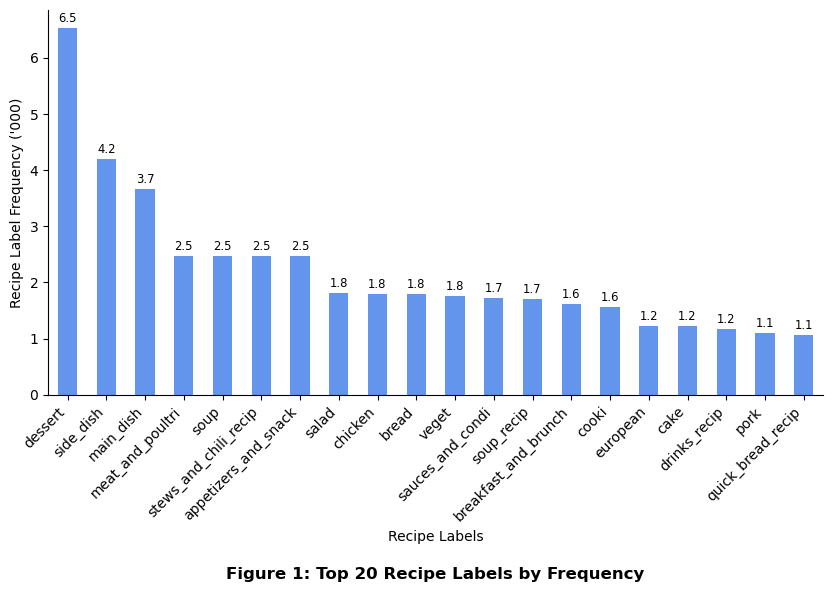

In [52]:
# Initiate figure object
fig, ax = plt.subplots(
    nrows = 1,
    ncols = 1,
    figsize = (10,5)
)

# Divide the sum by thousand to display in units of thousands.
plot_series = vectorized_labels.sum().\
    sort_values(ascending = False).\
    head(20)/1_000

# Plot series in a bar chart
plot_series.plot(
        ax = ax,
        kind = "bar",
        legend = None,
        color = "cornflowerblue"
    )

# Define space above each bar to display value
vertical_offset = plot_series.mean() * 0.05

# Define value to place on top of each bar
for xtick in ax.get_xticks():
    ax.text(
        x = xtick,
        y = plot_series[xtick] + vertical_offset,
        s = "{:.1f}".format(round(plot_series[xtick],2)),
        horizontalalignment = "center",
        size = "small",
        color = "black"
    )

# Settings to keep axis tidy
plt.xticks(rotation = 45, ha = "right")
plt.xlabel("Recipe Labels")
plt.ylabel("Recipe Label Frequency ('000)")
sns.despine()

# Add title
title = "Figure 1: Top 20 Recipe Labels by Frequency"
plt.title(f"{title}", y = -0.5, size = 12, fontweight = "bold")

# Save the figure in assets folder
image_file_name = f"../22_assets/images/{time.strftime('%Y%m%d-%H%M')}_{title}.png"
fig.savefig(
    fname = image_file_name,
    dpi = 300,
    format = "png",
    bbox_inches = "tight")

plt.show()

From the bar chart, it was observed that `dessert` was the most popular recipe label in allrecipes.com appearing 6.5K times out of 33.7K recipes analyzed. Next were `side_dish` and `main_dish`, which still keep in theme of the type of food presented at the table. However, in 4th to 7th places, a deviation from this theme was observed as `meat_and_poultry` recipes could be either a side dish or a main dish. 

Note the values presented could be an underestimate of "actual" values. For example, the token `side_dish` is also a part of `acorsn_squash_side_dish_recip` since both tokens refer to side dishes. This can be addressed in future iterations of text pre-processing.

## Bivariate Analysis with Average Rating

Aside from the univariate analysis of recipe label counts, the frequency of labels can also be analyzed with respect to other metrics such as the average rating of recipes. To calculate the average rating for each recipe label using harmonic means, the data must be further unpivoted and aggregated again by recipe labels.

As there were a total of 1,196 unique tokens generated and 33,691 recipes, unpivoting all the tokens would lead to a total of 40.3M rows. This may pose a memory problem for the local machine. As we are only interested in the top 20 recipe labels, the other tokens were excluded from the unpivoting process, leading instead to a smaller table of 0.7M rows. 

In [53]:
# Select only the top 20 recipe labels
top_20_labels = vectorized_labels.sum().sort_values(ascending = False).head(20).keys()

# Combine DataFrame of recipes with the top 20 labels
df = pd.concat(
    [
        df, # Original DataFrame with recipe titles and unprocessed labels
        vectorized_labels.loc[:, top_20_labels] # Top 20 tokens only
    ],
    axis = 1
)

# Visually examine the combined DataFrame
df.head(3).T

,0,1,2
recipe_url,https://www.allrecipes.com/recipe/83646/corned...,https://www.allrecipes.com/recipe/158799/stout...,https://www.allrecipes.com/recipe/8508920/miss...
title,Corned Beef Roast,Stout-Braised Lamb Shanks,Mississippi Chicken
label,"['Recipes', 'Main Dishes', 'Beef', 'Corned Bee...","['Cuisine', 'European', 'UK and Ireland', 'Iri...","['Recipes', 'Meat and Poultry', 'Chicken']"
rating_average,4.4,4.5,4.8
rating_count,68,45,4
dessert,0,0,0
side_dish,0,0,0
main_dish,1,0,0
meat_and_poultri,0,0,1
soup,0,0,0


As expected, only the columns representing the top 20 most popular recipe labels were preserved.

In [54]:
# Unpivot the DataFrame for harmonic mean calculation
df_1 = pd.melt(
    df.drop(columns = ["recipe_url", "label"]),
    id_vars = ["title", "rating_average", "rating_count"])

# Examine the unpivotted DataFrame
display(df_1.head())

,title,rating_average,rating_count,variable,value
0,Corned Beef Roast,4.4,68,dessert,0
1,Stout-Braised Lamb Shanks,4.5,45,dessert,0
2,Mississippi Chicken,4.8,4,dessert,0
3,Lasagna Flatbread,4.5,42,dessert,0
4,Prosciutto-Wrapped Pork Tenderloin with Crispy...,4.8,12,dessert,0


In the table above, the recipe labels and their frequency counts were repeated for all 33,691 recipes along with each recipes average rating and rating count. The average of averages, or the harmonic mean, can be calculated by using rating counts as weights when taking the average of `rating_average` for each recipe label.

In [55]:
# Re-aggregate the DataFrame to calculate the ratings for each recipe label
plot_df = df_1.groupby(
    by = "variable"
).agg(
    label_frequency = ("value","sum") # Number of ratings for each label across all recipes
)

# Examine re-aggregated DataFrame for plotting
display(plot_df.sort_values(by = "label_frequency", ascending = False).head())

,label_frequency
variable,
dessert,6527
side_dish,4200
main_dish,3661
meat_and_poultri,2476
soup,2473


As expected, the frequency of each label should tally with the previous univariate analysis.

In [56]:
# Calculate harmonic mean, using the number of ratings for each recipe as weights
# For each label, filter for only recipes which contain the label
plot_df["label_rating_average"] = df_1.loc[df_1["value"] != 0].\
    groupby(by = "variable").\
    apply(lambda x : np.average(x.rating_average, weights = x.rating_count))

# Sort and examine the resulting DataFrame for plotting
plot_df = plot_df.sort_values(
    by = ["label_frequency"],
    ascending = [False]
)

display(plot_df.head())

,label_frequency,label_rating_average
variable,,
dessert,6527,4.569788
side_dish,4200,4.547861
main_dish,3661,4.523881
meat_and_poultri,2476,4.497480
soup,2473,4.600751


Now that the average rating for each label has been calculated, a scatter plot can be used to visualize the relationship between label frequency and average rating.

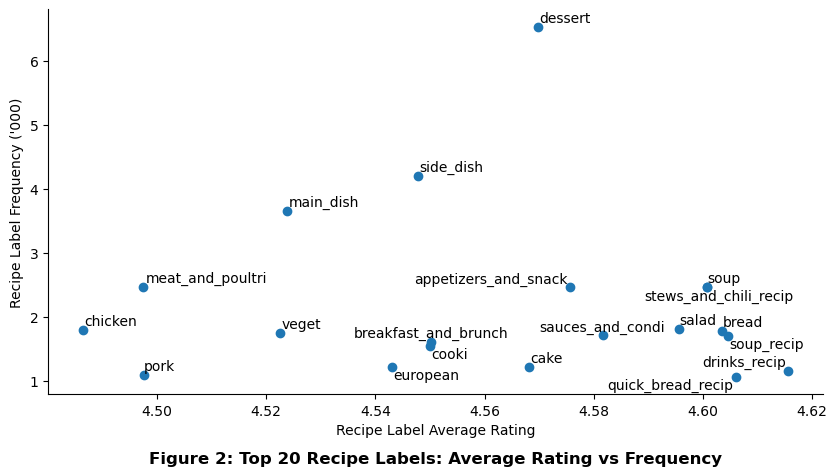

In [57]:
# Initiate figure object
fig, ax = plt.subplots(
    nrows = 1,
    ncols = 1,
    figsize = (10,5)
)

# For code simplicity, define x and y for plotting along with the recipe labels for each point
x = plot_df["label_rating_average"]
y = plot_df["label_frequency"]/1_000
labels = plot_df.index

# Generate scatterplot
plt.scatter(x,y)

# Generate annotations to place around each point
annotations = [plt.annotate(label, (x[i], y[i])) for i, label in enumerate(labels)]

# Apply adjust text function to optimize text annotation around points
adjust_text(annotations)

# Settings to keep axis tidy
plt.xlabel("Recipe Label Average Rating")
plt.ylabel("Recipe Label Frequency ('000)")
sns.despine()

# Add title
title = "Figure 2: Top 20 Recipe Labels: Average Rating vs Frequency"
plt.title(f"{title}", y = -0.2, size = 12, fontweight = "bold")

# Save the figure in assets folder
image_file_name = f"../22_assets/images/{time.strftime('%Y%m%d-%H%M')}_{title}.png"
fig.savefig(
    fname = image_file_name,
    dpi = 300,
    format = "png",
    bbox_inches = "tight")

plt.show()

Given two numerical features, further correlation and statistical analysis can be performed to further quantify any relationships observed. However, for the sake of article brevity, a simple visual analysis reveals the `dessert` label to be an outlier. Interestingly, labels pertaining to liquid recipes such as `soup_recip` and `drink_recip` were observed to have a higher average rating compared to labels about meat, such as `chicken` and `pork`.

# Conclusion

To summarize, the text recipe labels of 40,000 recipes from allrecipes.com were were preprocessed using NLP methods then analyzed to reveal that the most popular recipe label was `dessert`, and that among the top 20 labels, labels pertaining to liquids had higher average ratings compared to labels pertaining to solid foods such as meat. Deeper statistical analysis and further improvements in the formation of meaningful tokens were noted for future iterations. Finally, the vectorization of textual data also allows for applications in recipe similarity search and recommender systems in future endeavors. 

The Github notebook for this article can be found [here]().

# References and Acknowledgement

- [AdjustText](https://github.com/Phlya/adjustText) Documentation
- [How to Improve Label Placement for Matplotlib Scatter Chart](https://saturncloud.io/blog/how-to-improve-label-placement-for-matplotlib-scatter-chart/#:~:text=Matplotlib%20provides%20a%20feature%20called,the%20labels%20to%20minimize%20overlap.) by Saturn Cloud, 2023-07-18
- [Error in joblib.load when reading file from s3](https://stackoverflow.com/questions/59903471/error-in-joblib-load-when-reading-file-from-s3) by Mark_Anderson, 2020-01-24